In [336]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
from dataprep.eda import plot,plot_correlation,plot_missing
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font',family = 'Malgun Gothic')
plt.rc('axes',unicode_minus = False)

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import cross_val_score,GridSearchCV,StratifiedKFold,train_test_split,KFold
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor,StackingRegressor,VotingRegressor
from sklearn.linear_model import Ridge,Lasso,ElasticNet,LogisticRegression,LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from scipy.stats import skew

from keras import layers
from keras import models

In [2]:
train = pd.read_csv('movies_train.csv')
test = pd.read_csv('movies_test.csv')
sub = pd.read_csv('submission.csv')

## Rename Column

In [3]:
col = ['제목','배급사','장르','개봉일','상영시간','상영등급','감독','감독이전평균관객수','감독이전영화수','스텝','주연배우','관객수']

In [4]:
train.columns = col
test.columns = col[:-1]

In [5]:
plot_missing(train)

- 감독이전평균관객수의 결측치가 55%가 넘기때문에 삭제

## Missing Values

In [6]:
train.drop(['감독이전평균관객수'],axis = 1,inplace = True)

In [7]:
plot_missing(test)

- test셋도 같이 제거

In [8]:
test.drop(['감독이전평균관객수'],axis = 1, inplace = True)

- 주연배우, 감독이전영화수와는 상관관계가 거의 나타나지 않는다.

#### 개봉일 datetime으로 바꾸기

In [9]:
train['개봉일'] =train['개봉일'].astype('datetime64')

In [10]:
test['개봉일'] =test['개봉일'].astype('datetime64')

## EDA

In [11]:
plot(train)

In [12]:
plot_correlation(train,'관객수')

In [13]:
train.columns[:-1]

Index(['제목', '배급사', '장르', '개봉일', '상영시간', '상영등급', '감독', '감독이전영화수', '스텝',
       '주연배우'],
      dtype='object')

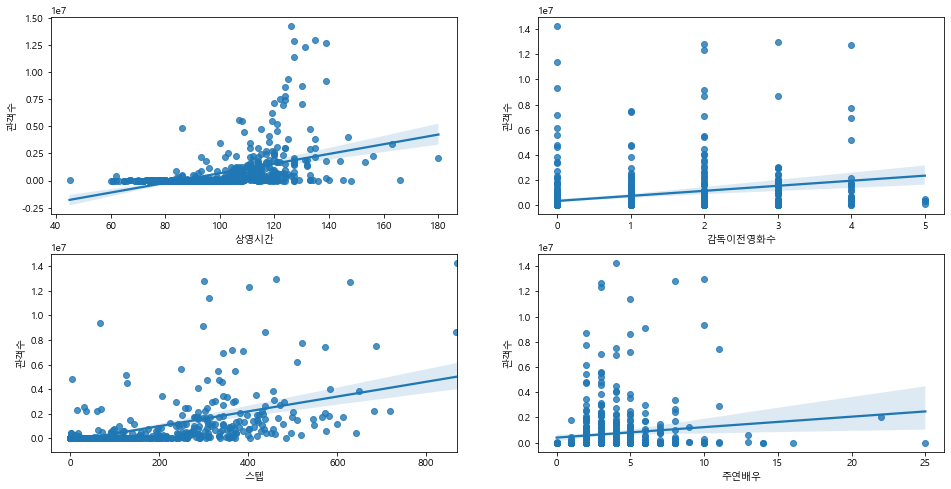

In [14]:
int_col = []
for c in train.columns :
    if train[c].dtype == 'int64' and c != '관객수':
        int_col.append(c)
        
fig,axs = plt.subplots(figsize=(16,8),ncols = 2, nrows = 2)
for i,feature in enumerate(int_col) :
    row = int(i/2)
    col = i%2
    sns.regplot(x = feature,y = '관객수',data = train, ax =axs[row][col])

<Figure size 432x288 with 0 Axes>

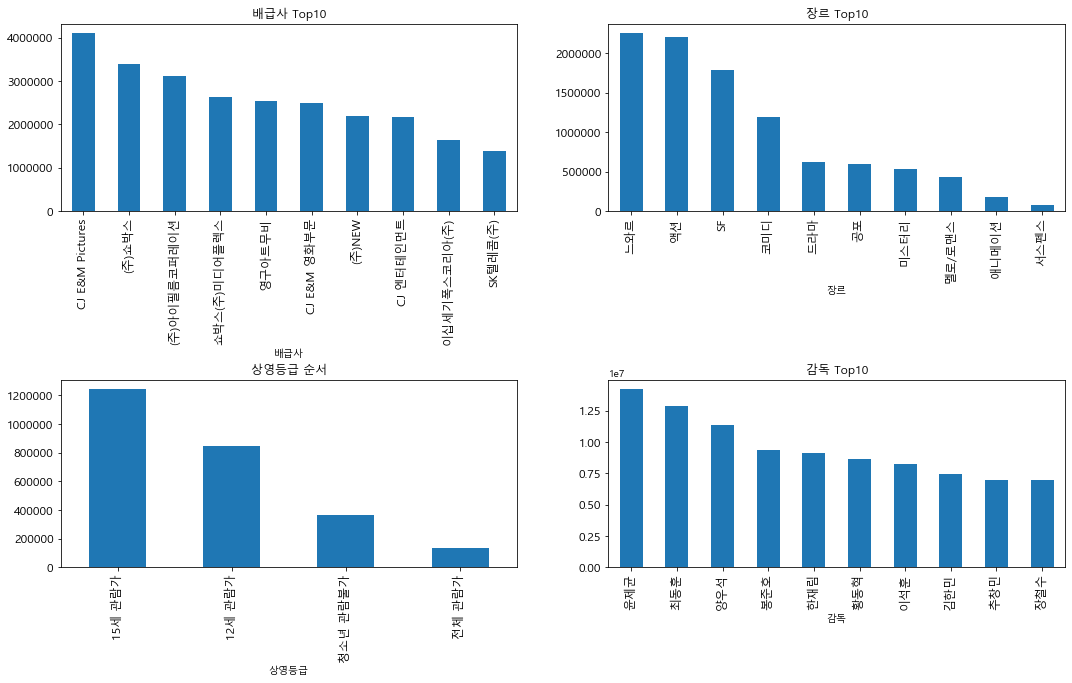

In [15]:
i = 0
plt.figure()
fig,ax = plt.subplots(2,2,figsize=(18,10))
for c in train.columns[1:] :
    if train[c].dtype =='object' :
        i+= 1
        plt.subplot(2,2,i)
        if len(list(train[c].unique())) > 10 :
            plt.title('{} Top10'.format(c))
            train.groupby(c)['관객수'].mean().sort_values(ascending=False)[:10].plot.bar()
        else :
            plt.title('{} 순서'.format(c))
            train.groupby(c)['관객수'].mean().sort_values(ascending =False).plot.bar()
    locs,labels = plt.xticks()
    plt.subplots_adjust(hspace= .9)
    plt.tick_params(axis = 'both',which='major',labelsize=12)
plt.show()

<Figure size 432x288 with 0 Axes>

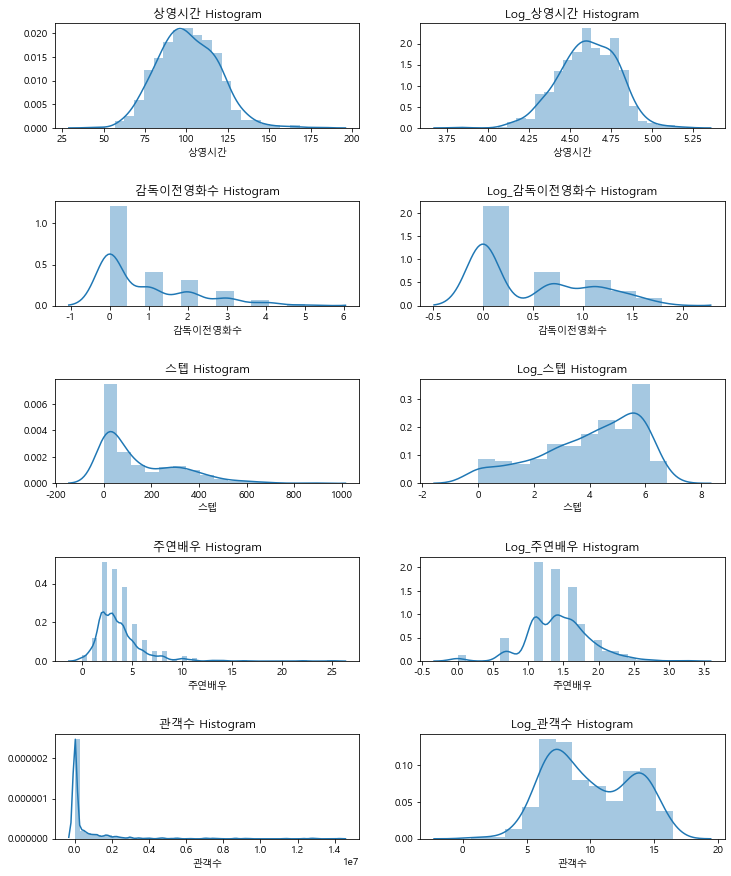

In [16]:
a = 0
plt.figure()
dist = []
fig,ax = plt.subplots(5,2,figsize=(12,15))
for col in train :
    if train[col].dtype =='int64' :
        dist.append(col)
        dist.append('Log_{}'.format(col))
for i,c in enumerate(dist) :
    a+= 1
    if a % 2 == 1:
        plt.subplot(5,2,a)
        if (i+1) % 2 == 1:
            plt.title('{} Histogram'.format(c))
            sns.distplot(train[c])
            plt.subplots_adjust(hspace=.7)
    else :
        plt.subplot(5,2,a)
        if (i+1) %2 == 0 :
            plt.title('{} Histogram'.format(c))
            sns.distplot(np.log1p(train['{}'.format(c)[4:]]))
plt.show()

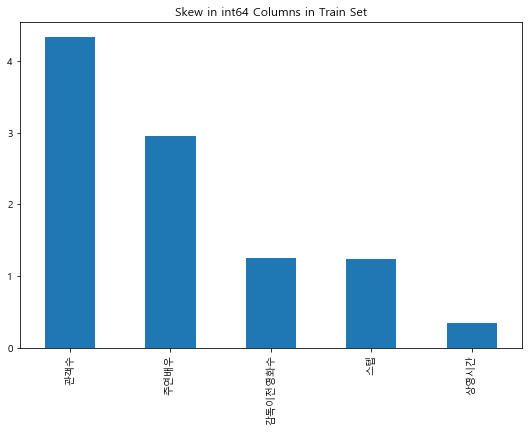

In [17]:
plt.title('Skew in int64 Columns in Train Set')
train.skew().sort_values(ascending = False).plot.bar(figsize=(9,6))
plt.show()

In [18]:
train.skew().sort_values(ascending = False)

관객수        4.332118
주연배우       2.950668
감독이전영화수    1.252762
스텝         1.233452
상영시간       0.345649
dtype: float64

- +- 2 일수록 첨도값 수정해주는 것이 좋다

#### 관객수 및 주연배우 log

In [19]:
for col in train.columns :
    if train[col].dtype =='int64' :
        if train[col].skew() >= 2:
            train[col] = np.log1p(train[col])

### Test

<Figure size 432x288 with 0 Axes>

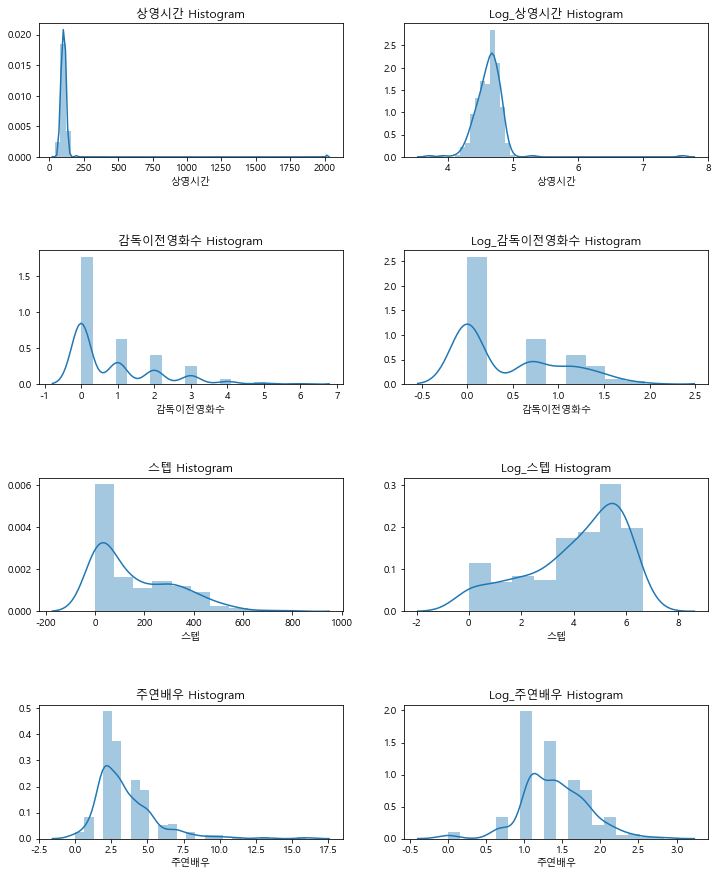

In [20]:
a = 0
plt.figure()
dist = []
fig,ax = plt.subplots(4,2,figsize=(12,15))
for col in test :
    if test[col].dtype =='int64' :
        dist.append(col)
        dist.append('Log_{}'.format(col))
for i,c in enumerate(dist) :
    a+= 1
    if a % 2 == 1:
        plt.subplot(4,2,a)
        if (i+1) % 2 == 1:
            plt.title('{} Histogram'.format(c))
            sns.distplot(test[c])
            plt.subplots_adjust(hspace=.7)
    else :
        plt.subplot(4,2,a)
        if (i+1) %2 == 0 :
            plt.title('{} Histogram'.format(c))
            sns.distplot(np.log1p(test['{}'.format(c)[4:]]))
plt.show()

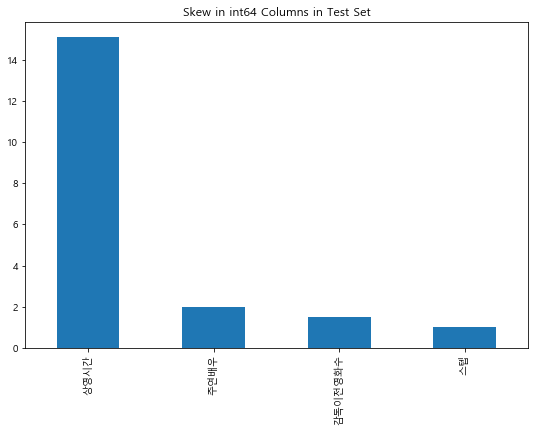

In [21]:
plt.title('Skew in int64 Columns in Test Set')
test.skew().sort_values(ascending = False).plot.bar(figsize=(9,6))
plt.show()

In [22]:
test.skew().sort_values(ascending = False)

상영시간       15.100734
주연배우        2.004420
감독이전영화수     1.488320
스텝          0.988132
dtype: float64

- train_set에서 주연배우만 바꿨기에 주연배우만 np.log1p로 수정

In [23]:
test['주연배우'] = np.log1p(test['주연배우'])

<Figure size 432x288 with 0 Axes>

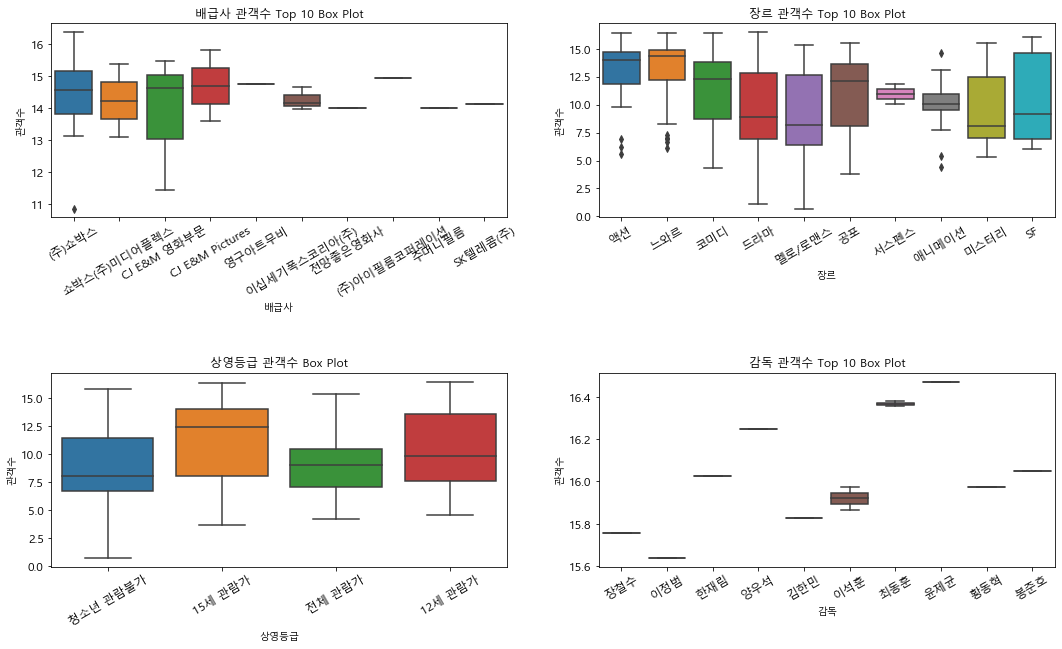

In [24]:
object_col = []
i = 0
plt.figure()
fig,ax = plt.subplots(2,2,figsize = (18,10))
for c in train.columns :
    if train[c].dtype=='object' and c != '제목' :
        object_col.append(c)
for c in object_col :
    i+= 1
    plt.subplot(2,2,i)
    if len(list(train[c].unique())) > 10 :
        plt.title('{} 관객수 Top 10 Box Plot'.format(c))
        sns.boxplot(x=c,y='관객수',data = train.loc[train[c].isin(train.groupby(c)['관객수'].mean().sort_values(ascending = False)[:10].index)])
    else :
        plt.title('{} 관객수 Box Plot'.format(c))
        sns.boxplot(x=c,y='관객수',data = train.loc[train[c].isin(train.groupby(c)['관객수'].mean().sort_values(ascending = False).index)])
    locs,labels = plt.xticks()
    plt.subplots_adjust(hspace=.8)
    plt.xticks(rotation = 30)
    plt.tick_params(axis = 'both',which='major',labelsize =12)
plt.show()

#### 배급사 삭제

In [25]:
train.drop(index = train.loc[train['관객수'] ==train.loc[train['배급사'] == '(주)쇼박스',:]['관객수'].min(),:].index,inplace = True)

### 날짜

In [31]:
years = []
months = []
days = []
for c in train['개봉일'] :
    years.append(c.year)
    months.append(c.month)
    days.append(c.day)
train['년도'] = years
train['월'] = months
train['일'] = days

In [37]:
years = []
months = []
days = []
for c in test['개봉일'] :
    years.append(c.year)
    months.append(c.month)
    days.append(c.day)
test['년도'] = years
test['월'] = months
test['일'] = days

In [40]:
del train['개봉일']
del test['개봉일']

In [46]:
plot(train,'년도','관객수')

In [55]:
def f(x) :
    if 1<= x <=3 :
        return '1분기'
    elif 4<=x<=6 :
        return '2분기'
    elif 7<=x<=9 :
        return '3분기' 
    else :
        return '4분기'
train['분기'] = train['월'].apply(lambda x: f(x))
test['분기'] = test['월'].apply(lambda x: f(x))

In [59]:
def f(x) :
    if 1<= x <=10 :
        return '월초'
    elif 11<=x<=20 :
        return '중간'
    else :
        return '월말'
train['월일'] = train['일'].apply(lambda x: f(x))
test['월일'] = test['일'].apply(lambda x: f(x))

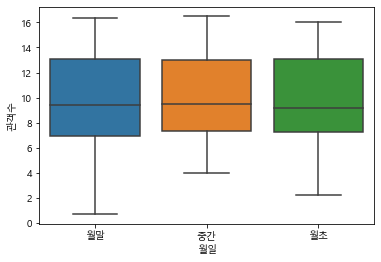

In [61]:
sns.boxplot(x='월일',y='관객수',data=train)

In [64]:
train.drop(['월','일'],axis = 1,inplace = True)
test.drop(['월','일'],axis = 1,inplace = True)

## One Hot Encoding

- 배급사, 장르,상영등급,감독,년도,분기,월일

#### OHE를 위해 년도 object로 변경

In [83]:
train['년도'] = train['년도'].astype('object')
test['년도'] = test['년도'].astype('object')

In [81]:
train_ohe = pd.concat([train,pd.get_dummies(train[['상영등급','년도','장르','분기','월일']])],axis = 1)

In [97]:
train_ohe.drop(['상영등급','년도','장르','분기','월일'],axis =1,inplace = True)

In [200]:
test_ohe= pd.concat([test,pd.get_dummies(test[['상영등급','년도','장르','분기','월일']])],axis = 1)
test_ohe.drop(['상영등급','년도','장르','분기','월일'],axis =1,inplace = True)

In [130]:
def ohe_top10(data,column,ohe) :
    movie = []
    for col in pd.get_dummies(data[column]).columns :
        if col not in data.groupby(column)['관객수'].mean().sort_values(ascending = False)[:10].index :
            movie.append(col)
    ohe = pd.concat([ohe,pd.get_dummies(data[column]).drop(movie,axis = 1)],axis = 1)
    ohe = ohe.drop(column,axis = 1)
    return ohe

In [133]:
train_ohe = ohe_top10(train,'배급사',train_ohe)

In [139]:
train_ohe = ohe_top10(train,'감독',train_ohe)

In [225]:
movie = []
for col in pd.get_dummies(train['배급사']).columns :
    if col in train.groupby('배급사')['관객수'].mean().sort_values(ascending = False)[:10].index :
        movie.append(col)
        
director = []
for col in pd.get_dummies(train['감독']).columns :
    if col in train.groupby('감독')['관객수'].mean().sort_values(ascending = False)[:10].index :
        director.append(col)

In [230]:
test_movie = []
for col in pd.get_dummies(test['배급사']) :
    if col not in movie :
        test_movie.append(col)
        
test_director = []
for col in pd.get_dummies(test['감독']) :
    if col not in director :
        test_director.append(col)

In [234]:
test_ohe = pd.concat([test_ohe,pd.get_dummies(test['배급사']).drop(test_movie,axis = 1)],axis = 1)
test_ohe.drop('배급사',axis = 1,inplace = True)

In [235]:
test_ohe = pd.concat([test_ohe,pd.get_dummies(test['감독']).drop(test_director,axis = 1)],axis = 1)
test_ohe.drop('감독',axis = 1,inplace = True)

In [237]:
name = test_ohe['제목']
test_ohe.drop('제목',axis = 1,inplace = True)

In [260]:
train_ohe = train_ohe.iloc[:,:35]
test_ohe = test_ohe.iloc[:,:33]

In [311]:
train_ohe.drop('제목',axis = 1,inplace = True)

## Modeling

In [142]:
def rmse(y,pred) :
    return np.sqrt(mean_squared_error(y,pred))

In [263]:
y_target = train_ohe['관객수']
X_target = train_ohe.drop('관객수',axis = 1)

In [264]:
X_train,X_test,y_train,y_test = train_test_split(X_target,y_target,test_size = 0.25,random_state = 156)

### Linear Regression,Ridge,Lasso

In [265]:
def get_rmse(model,train,test,ytrain,yest) :
    model.fit(train,ytrain)
    pred = model.predict(test)
    mse = mean_squared_error(yest,pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__,'RMSE : {}'.format(np.round(rmse,3)))
    return rmse

def get_rmses(models,train,test,ytrain,yest) :
    rmses = []
    for model in models :
        rmse = get_rmse(model,train,test,ytrain,yest)
        rmses.append(rmse)
    return rmses

In [266]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

In [267]:
models = [lr,ridge,lasso]

In [268]:
get_rmses(models,X_train,X_test,y_train,y_test)

LinearRegression RMSE : 2.106
Ridge RMSE : 2.101
Lasso RMSE : 2.176


[2.1058510585629304, 2.1013822012514383, 2.1762186881550267]

In [342]:
def print_best_params(model,params,train,test,y_train,y_test) :
    model.fit(train,y_train)
    grid_model = GridSearchCV(model,param_grid=params,
                                     scoring = 'neg_mean_squared_error',cv = 5)
    grid_model.fit(train,y_train)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{0} 5 Folds 최적 평균 RMSE : {1}, 최적 alpha :{2}'.format(model.__class__.__name__,
                                                              np.round(rmse,4),grid_model.best_params_))

In [270]:
ridge_params = {'alpha' : [0.05,0.1,1,5,10,15,20,50,100]}
lasso_params = {'alpha' : [0.001,0.005,0.008,0.01,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge,ridge_params,X_train,X_test,y_train,y_test)
print_best_params(lasso,lasso_params,X_train,X_test,y_train,y_test)

Ridge 5 Folds 최적 평균 RMSE : 1.9642, 최적 alpha :{'alpha': 5}
Lasso 5 Folds 최적 평균 RMSE : 1.9653, 최적 alpha :{'alpha': 0.01}


In [271]:
ridge = Ridge(alpha=5)
ridge.fit(X_train,y_train)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [292]:
def regression_csv(model,name) :
    model.fit(X_train,y_train)
    predict = model.predict(test_ohe)
    sub['box_off_num'] = np.expm1(predict)
    sub.to_csv('sub_{}.csv'.format(name),index = False,encoding = 'cp949')

In [294]:
lasso = Lasso(alpha=0.01)
regression_csv(lasso,'lasso')

### 회귀트리

### RandomForest

In [301]:
rf = RandomForestRegressor(max_features=5,
                           min_samples_leaf=1,
                           min_samples_split=2,
                           n_estimators=300,
                           random_state=0)

In [316]:
def rmse(y,pred) :
    return np.sqrt(mean_squared_error(y,pred))

In [317]:
rmse(y_test,rf.predict(X_test))

1.977128706631931

In [303]:
regression_csv(rf,'randomforest')

In [318]:
rf = RandomForestRegressor(random_state=1217,
                           max_features= 3,
                           min_samples_leaf= 2,
                           min_samples_split=2,
                           n_estimators=500)

In [320]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=1217, verbose=0, warm_start=False)

In [324]:
rf_params = {'max_features' : [3,5,7],
            'min_samples_leaf' : [2,4,6],
            'min_samples_split' : [2,6,8],
            'n_estimators' : [500,1000],'random_state' : [0,1217]}

In [327]:
rf = RandomForestRegressor(random_state=1217,
                           max_features= 7,
                           min_samples_leaf= 2,
                           min_samples_split=2,
                           n_estimators=1000)

In [328]:
regression_csv(rf,'RandomForest_Grid')

### GradientBoost

In [339]:
gb = GradientBoostingRegressor()

In [340]:
gb_params = {'n_estimators' : [100,500,1000],
            'learning_rate' : [0.05,0.1,0.3,0.5]}

In [343]:
print_best_params(gb,gb_params,X_train,X_test,y_train,y_test)

GradientBoostingRegressor 5 Folds 최적 평균 RMSE : 1.9729, 최적 alpha :{'learning_rate': 0.1, 'n_estimators': 100}


In [344]:
gb = GradientBoostingRegressor(learning_rate=0.1,n_estimators=100)

In [345]:
gb.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [346]:
regression_csv(gb,'gb')

### XGBoost

In [295]:
xgb_params = {'n_estimators' : [1000]}
xgb_reg = XGBRegressor(n_estimators=1000,learning_rate=0.05,
                      colsample_bytree=0.5,subsample=0.8)
print_best_params(xgb_reg,xgb_params,X_train,X_test,y_train,y_test)

[21:25:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:25:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:25:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:25:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:25:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:25:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:25:56] WARNI

In [351]:
xgb = XGBRegressor(n_jobs=-1,random_state=0)
xgb_params = {'n_estimators' : [500,1000],'learning_rate' : [0.01,0.05,0.1],
             'colsample_bytree' : [0.1,0.5,0.7],'subsample' : [0.5,0.7,0.9],
             'max_depth' : [3,5,7]}
print_best_params(xgb,xgb_params,X_train,X_test,y_train,y_test)

[22:12:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:41] WARNI

[22:12:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:58] WARNI

[22:13:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:14] WARNI

[22:13:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:32] WARNI

[22:13:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:13:50] WARNI

[22:14:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:06] WARNI

[22:14:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:27] WARNI

[22:14:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:57] WARNI

[22:15:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:15:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:15:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:15:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:15:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:15:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:15:19] WARNI

[22:15:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:15:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:15:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:15:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:15:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:15:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:15:51] WARNI

[22:16:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:16:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:16:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:16:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:16:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:16:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:16:14] WARNI

[22:16:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:16:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:16:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:16:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:16:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:16:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:16:39] WARNI

[22:17:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:10] WARNI

[22:17:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:17:42] WARNI

[22:18:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:12] WARNI

[22:18:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:43] WARNI

[22:19:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:15] WARNI

In [352]:
xgb = XGBRegressor(colsample_bytree=0.7,learning_rate=0.01,max_depth=3,n_estimators=500,subsample=0.5,n_jobs=-1,random_state=0)

In [353]:
regression_csv(xgb,'xgb')

[22:20:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### LightGBM

In [296]:
lgbm_params = {'n_estimators' : [1000]}
lgbm = LGBMRegressor(n_estimators=1000,n_jobs=-1,learning_rate=0.05,num_leaves=4,
             subsample=0.6,colsample_bytree=0.4,reg_lambda=10)
print_best_params(lgbm,lgbm_params,X_train,X_test,y_train,y_test)

LGBMRegressor 5 Folds 최적 평균 RMSE : 2.0795, 최적 alpha :{'n_estimators': 1000}


In [355]:
lgbm = LGBMRegressor(num_iterations = 1000, 
                                learning_rate = 0.05,
                     boosting = 'dart',
                         Metric = 'regression_l2', n_jobs=-1)

In [359]:
lgbm = LGBMRegressor(n_jobs=-1,random_state=0)
lgbm_params = {'num_iterations' : [500,1000],'max_depth' : [3,5,7],
              'num_leaves' : [2,4,6],'learning_rate' : [0.01,0.05,0.1],
              'boosting' : ['gbdt','dart','rf'],'Metric' : ['regression_l2','regression_l1']}
print_best_params(lgbm,lgbm_params,X_train,X_test,y_train,y_test)

LGBMRegressor 5 Folds 최적 평균 RMSE : 1.9824, 최적 alpha :{'Metric': 'regression_l2', 'boosting': 'gbdt', 'learning_rate': 0.01, 'max_depth': 5, 'num_iterations': 500, 'num_leaves': 6}


In [360]:
lgbm = LGBMRegressor(n_jobs=-1,random_state=0,Metric = 'regression_l2',boosting = 'gbdt',learning_rate=0.01,
                    max_depth=5,num_iterations = 500,num_leaves=6)

In [361]:
regression_csv(lgbm,'lgbm')

### CROSS_VAL_SCORE

In [ ]:
from sklearn.model_selection import cross_val_predict

In [297]:
def get_model_cv_prediction(model,X_data,y_target) :
    neg_mse_scores = cross_val_score(model,X_data,y_target,scoring ='neg_mean_squared_error',cv = 5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    
    print('#####',model.__class__.__name__,'#####')
    print('5 Folds 평균 RMSE : {}'.format(avg_rmse))

In [362]:
rf = RandomForestRegressor(random_state=1217,
                           max_features= 7,
                           min_samples_leaf= 2,
                           min_samples_split=2,
                           n_estimators=1000)
gb = GradientBoostingRegressor(learning_rate=0.1,n_estimators=100)
xg = XGBRegressor(colsample_bytree=0.7,learning_rate=0.01,max_depth=3,n_estimators=500,subsample=0.5,n_jobs=-1,random_state=0)
lgbm = LGBMRegressor(n_jobs=-1,random_state=0,Metric = 'regression_l2',boosting = 'gbdt',learning_rate=0.01,
                    max_depth=5,num_iterations = 500,num_leaves=6)

In [363]:
models = [rf,gb,xg,lgbm]

In [364]:
for model in models :
    get_model_cv_prediction(model,X_train,y_train)

##### RandomForestRegressor #####
5 Folds 평균 RMSE : 1.903384980304288
##### GradientBoostingRegressor #####
5 Folds 평균 RMSE : 1.95652436588636
[22:31:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:31:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:31:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:31:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:31:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
##### XGBRegressor #####
5 Folds 평균 R

### Stacking Ensemble

In [369]:
def get_stacking_base_datasets(model,X_train_n,y_train_n,X_test_n,n_folds) :
    kf =KFold(n_splits=n_folds,shuffle=False,random_state = 0)
    train_fold_pred = np.zeros((X_train.shape[0],1))
    test_pred = np.zeros((X_test.shape[0],n_folds))
    print(model.__class__.__name__,'model 시작')
    
    for folder_counter, (train_index,valid_index) in enumerate(kf.split(X_train_n)) :
        print('\t Fold Set : {}'.format('folder_counter'),'시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        model.fit(X_tr,y_tr)
        train_fold_pred[valid_index,:] = model.predict(X_te).reshape(-1,1)
        test_pred[:,folder_counter] = model.predict(X_test_n)
        
    test_pred_mean = np.mean(test_pred,axis = 1).reshape(-1,1)
    return train_fold_pred,test_pred_mean

In [193]:
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

In [370]:
ridge_train,ridge_test = get_stacking_base_datasets(ridge,X_train_n,y_train_n,X_test_n,5)
lasso_train,lasso_test = get_stacking_base_datasets(lasso,X_train_n,y_train_n,X_test_n,5)
xg_train,xg_test = get_stacking_base_datasets(xg,X_train_n,y_train_n,X_test_n,5)
lgbm_train,lgbm_test = get_stacking_base_datasets(lgbm,X_train_n,y_train_n,X_test_n,5)
gb_train,gb_test = get_stacking_base_datasets(gb,X_train_n,y_train_n,X_test_n,5)
rf_train,rf_test = get_stacking_base_datasets(rf,X_train_n,y_train_n,X_test_n,5)

Ridge model 시작
	 Fold Set : folder_counter 시작
	 Fold Set : folder_counter 시작
	 Fold Set : folder_counter 시작
	 Fold Set : folder_counter 시작
	 Fold Set : folder_counter 시작
Lasso model 시작
	 Fold Set : folder_counter 시작
	 Fold Set : folder_counter 시작
	 Fold Set : folder_counter 시작
	 Fold Set : folder_counter 시작
	 Fold Set : folder_counter 시작
XGBRegressor model 시작
	 Fold Set : folder_counter 시작
[22:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 Fold Set : folder_counter 시작
[22:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 Fold Set : folder_counter 시작
[22:42:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 Fold Set : folder_counter 시작
[22:42:01] WARNING: C:

In [371]:
Stack_final_X_train = np.concatenate((ridge_train,lasso_train,xg_train,lgbm_train,rf_train),axis = 1)
Stack_final_X_test = np.concatenate((ridge_test,lasso_test,xg_test,lgbm_test,rf_test),axis = 1)

In [372]:
meta_model_lasso = Lasso(alpha = 0.0005)
meta_model_lasso.fit(Stack_final_X_train,y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test,final)
rmse = np.sqrt(mse)
print('Good Model RMSE : {}'.format(rmse))

Good Model RMSE : 1.988028311279371
